# Data Declaration - Scott Wilkinson (V00887986) 

A notebook declaring the data set to be used for assignments pertaining to the first half of PHYS 555, a course on Machine Learning applications to physics and astronomy. 

To do so, we must first import the necessary Python packages.

In [15]:
# importing packages used in notebook
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import pymysql, corner, os

My field of study is of galaxy morphology and evolution. Specifically, I tend to focus on the observability and detection of galaxy mergers or post-mergers. Wilkinson et al. (in prep.) approaches this from the perspective of post-starburst galaxies. In my next project, I hope to determine how many mergers are missed by the methods used within Wilkinson et al. (in prep.). To test how many mergers are detected, it is best to start with a sample of galaxies that you KNOW are mergers. Cosmological simulations provide just that: a sample of galaxies that have recently merged, with all details (mass, time since merger, etc.) known as truth rather than a measurement/estimation. 

In this course, I wish to answer a series of related but slightly different questions:

1. Can a neural network use statistical morphology metrics to reliably identify post-merger galaxies and pre-merger galaxies (tabular - classification)?

2. Can a neural network use statistical morphology metrics to predict when a galaxy merger will (or did) coalesce (tabular - regression)?

3. Can a neural network use a galaxy's semi-realistic image to reliably identify post-merger galaxies and pre-merger galaxies (image - classification)?

4. Can a neural network use a galaxy's semi-realistic image to predict when a galaxy merger will (or did) coalesce (image - regression)?

To answer these questions, I need tabular morphology data and realistic imaging for post-merger and pre-merger galaxies. I have already generated semi-realistic images for all galaxies in the IllustrisTNG cosmological simulation (~300,000) at varying levels of image quality (PSF blurring and sky noise). Moreover, I have a morphology catalogue for CFIS-realistic images generated using RealSimCFIS pipeline (Bottrell et al. 2019) and used in Bickley et al. (2021). I will start with these images and their derived non-parametric morphology statistics. 

## Importing Morphology Data

In [16]:
#Query SQL for morphology data
# connects to database
db = pymysql.connect(host = 'lauca.phys.uvic.ca', db = 'sdss', user = 'swilkinson', passwd = '123Sdss!@#')
# select morphology params that have unflagged morphology fits
x = 'SELECT  dbID, asymmetry, shape_asymmetry, gini_m20_merger, concentration, outer_asymmetry, deviation, multimode, intensity \
    FROM simCFIS_morph\
    WHERE flag_morph = 0\
    AND asymmetry > -1'
c = db.cursor()
c.execute(x)
db_data = c.fetchall()
c.close()
db.close()

# save names as a string
names_morph = np.array(db_data, dtype = str).T[0]

# save rest of data as floats
morph = np.array(db_data, dtype = float).T[1:]

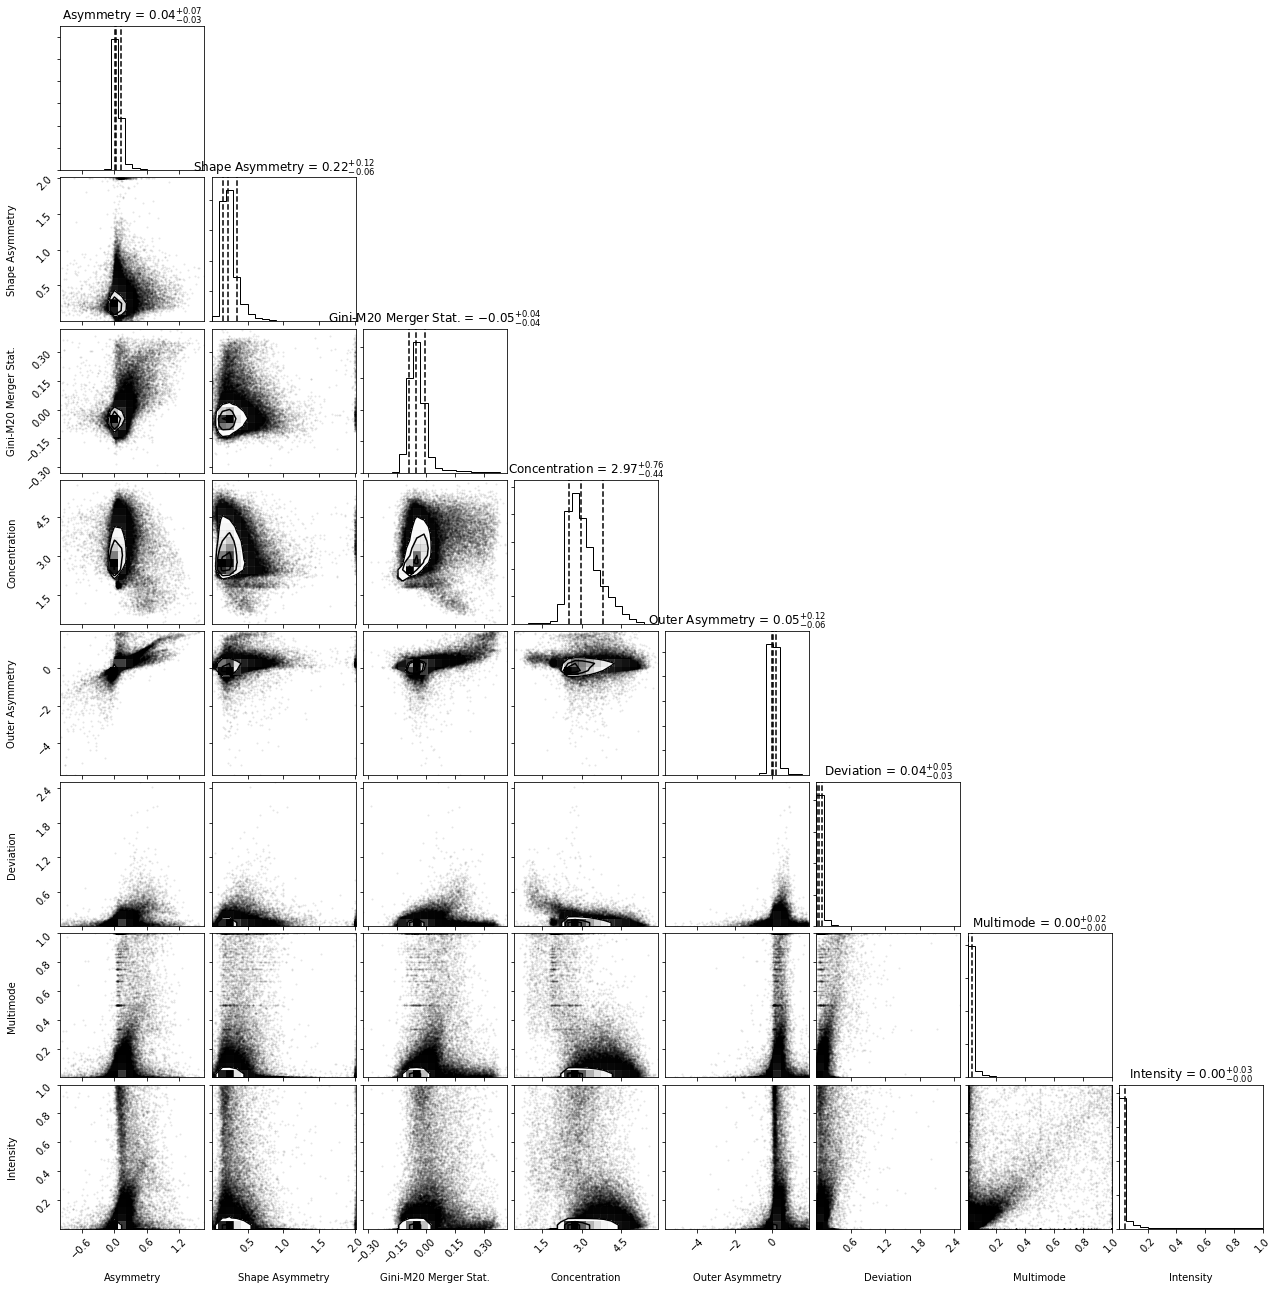

In [17]:
# generate labels for plot
labels = ['Asymmetry', 'Shape Asymmetry', 'Gini-M20 Merger Stat.', 'Concentration', 'Outer Asymmetry', 'Deviation', 'Multimode', 'Intensity']

# generate a corner plot to simultaneously visualize the distributions and correlations between input
# the quantiles selected represent 1-sigma deviations from the median
corner.corner(morph.T, labels = labels, quantiles = [0.14,0.50,0.86], show_titles = True)

plt.show()

There are non-trivial correlations between the data, this indicates that using feature extraction may be beneficial to our future models. 

There are outliers but due to the chaotic nature of galaxy mergers, I am hesistant to remove them. The morphology fits were successful so we will trust the data. The outliers may be caused by the mergers.

## Importing Data for all galaxies in IllustrisTNG100-1

In this section, I intend to briefly show some of the values from the solution that may be used. 

In [4]:
#Query MySQL
db = pymysql.connect(host = 'lauca.phys.uvic.ca', db = 'IllustrisTNG100_1', user = 'swilkinson', passwd = '123Sdss!@#')
x = 'SELECT e.DB_ID, e.r1, e.r2, e.Mstar, e.rsep, e.Tpostmerger, e.MassRatio, e.Tuntilmerger\
    FROM Environment e \
    WHERE rsep<999\
    AND MassRatio>0'
c = db.cursor()
c.execute(x)
db_data = c.fetchall()
c.close()
db.close()

names_db = np.array(db_data, dtype = str).T[0]
r1 = np.array(db_data, dtype = float).T[1]
r2 = np.array(db_data, dtype = float).T[2]
Mstar = np.array(db_data, dtype = float).T[3]
rsep = np.array(db_data, dtype = float).T[4]
Tpm = np.array(db_data, dtype = float).T[5]
mu = np.array(db_data, dtype = float).T[6]
Tum = np.array(db_data, dtype = float).T[7]

# add a zero to DB_ID to match formatting of the morphology table
names_db = np.array(['0'+n for n in names_db])

In [5]:
# matching the two catalogues
match, idx_morph, idx_db = np.intersect1d(names_morph, names_db, return_indices = True)

### Visualize the distributions and correlations between the possible targets

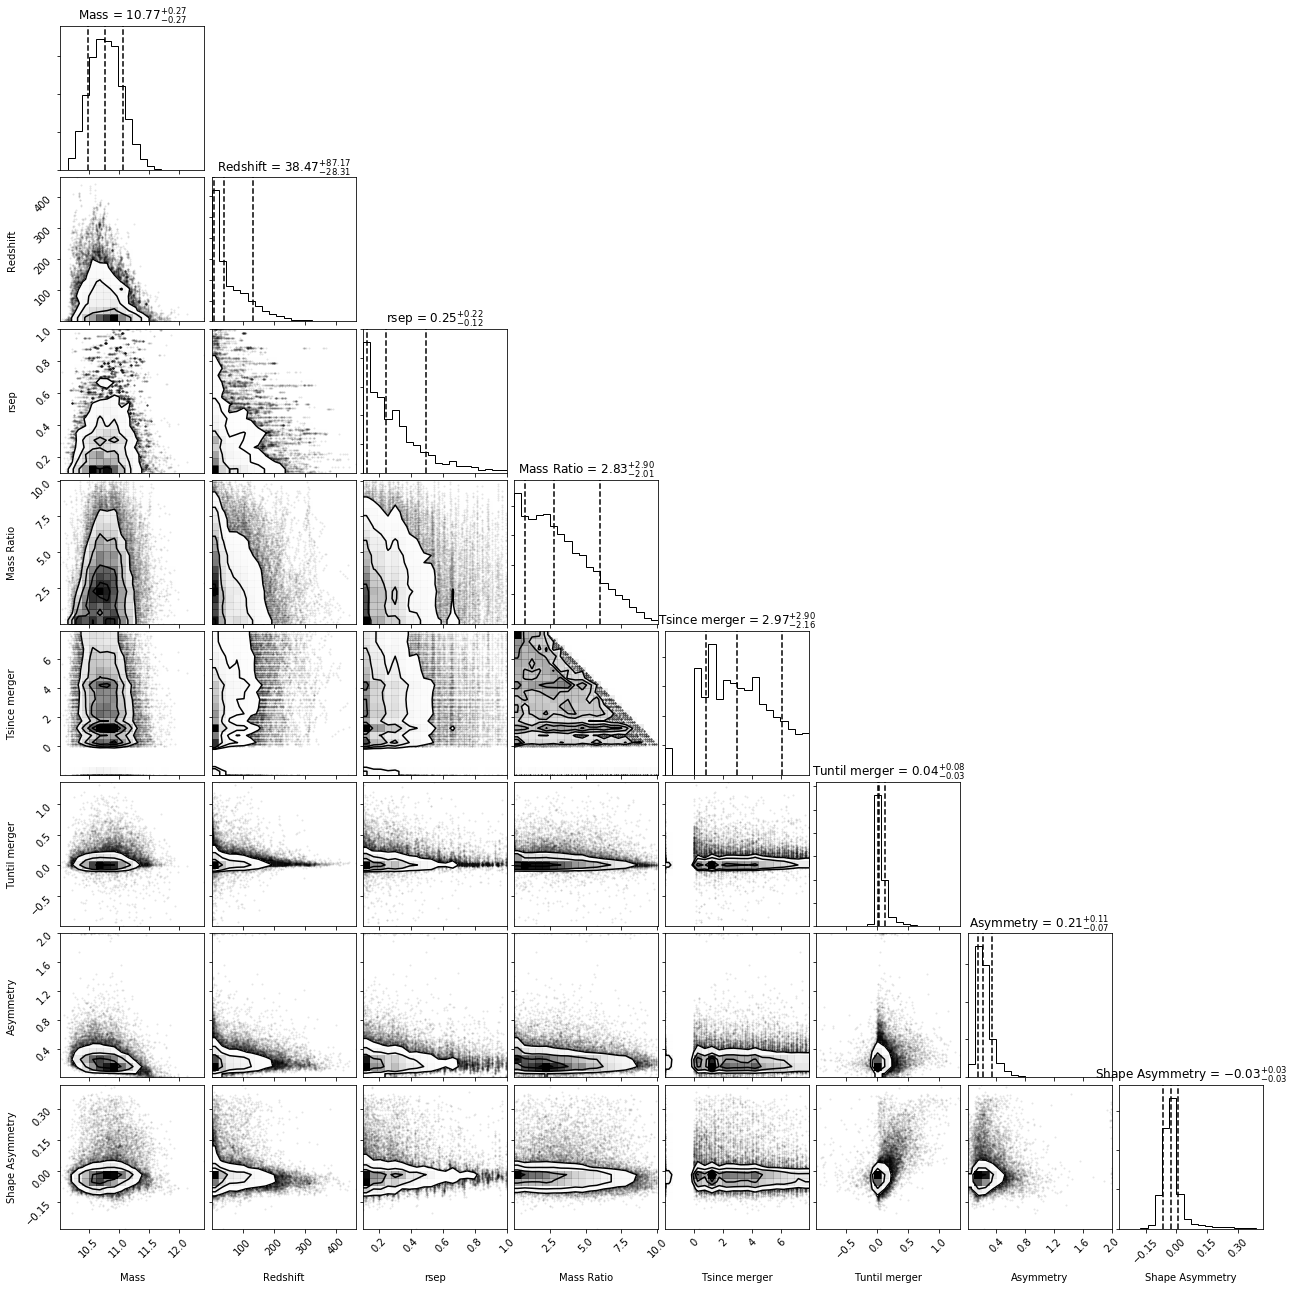

In [6]:
# combining data products for plotting purposes only
data = np.stack([Mstar[idx_db],rsep[idx_db],mu[idx_db],Tpm[idx_db], Tum[idx_db], morph[0][idx_morph],morph[1][idx_morph],morph[2][idx_morph]])

#        ** ----------------  potential targets  ------------------------------**  ** ---------- potential inputs ----------**
names = ['Mass', 'Redshift', 'rsep', 'Mass Ratio', 'Tsince merger', 'Tuntil merger', 'Asymmetry', 'Shape Asymmetry', 'G-M20']

# generate a corner plot to simultaneously visualize the distributions and correlations between potential inputs and potential targets
# the quantiles selected represent 1-sigma deviations from the median
corner.corner(data.T, labels = names, quantiles = [0.14,0.50,0.86], show_titles = True)

plt.show()

# Merger Sample Selection

## Selecting a Sample of Pre-Merger Galaxies

Here is the reasoning behind my selection cuts:

1.  snap >= 50 requires z<1 in the simulation (ie. enough time for galaxies to form, evolve and begin to merge)
2. rsep > 0 requires there to be two merging galaxies that are not on top of each other yet
3. mass ratio > 0.1, the merger will be significant when it occurs
4. Flaguntilmerger = 1 ensures the merger is true and not a projection effect that confuses the `subfind` code
5. Tuntilmerger < 0.25 ensures the merger will happen soon (< 250 Myr) and the galaxies have begun to gravitationally interact
6. Tpostmerger > 0.75 ensures no recent has occurred that would cause the disturbed morphology

In [7]:
#Query MySQL with reasoning described above
db = pymysql.connect(host = 'lauca.phys.uvic.ca', db = 'IllustrisTNG100_1', user = 'swilkinson', passwd = '123Sdss!@#')
x ='SELECT e.DB_ID, e.Mstar, e.Tuntilmerger, e.MassRatiountilmerger\
    FROM Environment e \
    WHERE snapNum>=50\
    AND rsep>0 \
    AND MassRatiountilmerger>=0.1\
    AND Flaguntilmerger = 1\
    AND Tuntilmerger < 0.25\
    AND Tpostmerger > 0.75'
c = db.cursor()
c.execute(x)
db_data = c.fetchall()
c.close()
db.close()

names_db_pre = np.array(db_data, dtype = str).T[0]
Mstar_pre = np.array(db_data, dtype = float).T[1]
Tum_pre = np.array(db_data, dtype = float).T[2]
mu_pre = np.array(db_data, dtype = float).T[3]

# give time before merger a negative value
Tum_pre *= -1

# differentiate pre-merger galaxies that merge within the next snapshot from post-merger galaxies
#   that have merged within the last snap shot by adding / subtracting 0.1Gyr (approx the middle of a snapshot)
Tum_pre[Tum_pre == 0] = -0.1

# add 0 to match formatting with morphology catalogue
names_db_pre = np.array(['0'+n for n in names_db_pre])

print('There are {} pre-merger galaxies.'.format(len(names_db_pre)))

# match the two catalogues
match, idx_morph_pre, idx_pre = np.intersect1d(names_morph, names_db_pre, return_indices = True)

print('There are {} pre-merger galaxies with flag-free morphology data.'.format(len(names_db_pre[idx_pre])))

There are 3892 pre-merger galaxies.
There are 1454 pre-merger galaxies with flag-free morphology data.


## Selecting a Sample of Post-Merger Galaxies

Here is the reasoning behind my selection cuts:

1. snap >= 50 requires z<1 in the simulation (ie. enough time for galaxies to form, evolve and begin to merge)
2. mass ratio > 0.1, the merger that occurred was significant
3. Flagpostmerger = 1 ensures the merger is true and not a projection effect that confuses the `subfind` code
4. Tpostmerger < 0.75 requires a merger to have occurred in the last 750 Myr
5. rsep > 25 and Tuntilmerger < 0.25 requires there to be no nearby galaxies about to cause another merger in the next 250 Myr

In [8]:
#Query MySQL with the reasoning listed above
db = pymysql.connect(host = 'lauca.phys.uvic.ca', db = 'IllustrisTNG100_1', user = 'swilkinson', passwd = '123Sdss!@#')
x ='SELECT e.DB_ID, e.Mstar, e.Tpostmerger, e.MassRatio\
    FROM Environment e \
    WHERE snapNum>=50\
    AND MassRatio>=0.1\
    AND Flagpostmerger = 1\
    AND Tpostmerger < 0.75\
    AND rsep>25\
    AND Tuntilmerger > 0.25'
c = db.cursor()
c.execute(x)
db_data = c.fetchall()
c.close()
db.close()

names_db_post = np.array(db_data, dtype = str).T[0]
Mstar_post = np.array(db_data, dtype = float).T[1]
Tpm_post = np.array(db_data, dtype = float).T[2]
mu_post = np.array(db_data, dtype = float).T[3]

# add 0 to match formatting with morphology catalogue
names_db_post = np.array(['0'+n for n in names_db_post])

# differentiate pre-merger galaxies that merge within the next snapshot from post-merger galaxies
#   that have merged within the last snap shot by adding / subtracting 0.1Gyr (approx the middle of a snapshot)
Tpm_post[Tpm_post == 0] = 0.1

print('There are {} post-merger galaxies.'.format(len(names_db_post)))

# match with morphology catalogue
match, idx_morph_post, idx_post = np.intersect1d(names_morph, names_db_post, return_indices = True)

print('There are {} post-merger galaxies with flag-free morphology data.'.format(len(names_db_post[idx_post])))

names_db_post = names_db_post[idx_post]
Mstar_post = Mstar_post[idx_post]
Tpm_post = Tpm_post[idx_post]
mu_post = mu_post[idx_post]

There are 7015 post-merger galaxies.
There are 4725 post-merger galaxies with flag-free morphology data.


# Imaging Examples

In the following cell, I build a function to allow us to easily view pre- and post-merger galaxies.

In [9]:
def show_image(db_id, t, pre_post = 'post', user = 'Scott'):
    
    # db ID is a unique identifier based on the snapshot and subfindID, separated by a '_'
    snap, sub = db_id.split('_')
    
    # file name
    fn = 'map_new_Mstar_TNG100-1_' + sub + '_' + snap + '_50kpc_2048_sci_.fits'
    
    # file path to location on cedar
    #cfp = '/home/swilk/projects/rrg-jfncc/Illustris-TNG/StellarMaps/TNG100-1/4cams/0' + str(header['SNAPNUM']) +'/'
    cfp = '/home/swilk/projects/rrg-jfncc/Illustris-TNG/mock_surv_sci/'
    
    if user == 'Scott':
        
        # local file path
        lfp = '/astro/swilkinson/Desktop/PHYS555/TNGIms/'
    
        # copy each over from Cedar
        os.system('scp swilk@cedar.computecanada.ca:{} {} '.format(cfp+fn, lfp))

    if user == 'Hossen':
    
        lfp = './TNGIms/'
    
    
    # load into memory
    hdu = pyfits.open(lfp+fn, mode = 'readonly')
    header = hdu[0].header
    image = hdu[0].data

    # show image
    plt.imshow(np.log10(image), cmap = 'gray', origin = 'lower', aspect = 'equal')
    
    # add relevant info
    if pre_post == 'pre':
        plt.xlabel('Time Until Merger: {} Gyr'.format(t))
        plt.title('IllustrisTNG Pre-Merger ({})'.format(db_id))
    elif pre_post == 'post':
        plt.xlabel('Time Since Merger: {} Gyr'.format(t))
        plt.title('IllustrisTNG Post-Merger ({})'.format(db_id))
        
    plt.show()

### Pre-Mergers:

Show the first 20 pre-mergers:

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log10


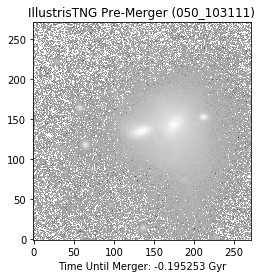

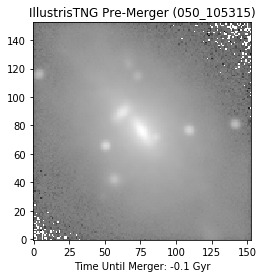

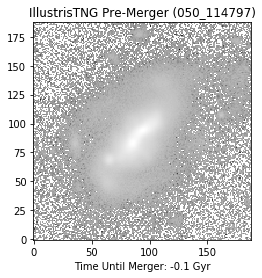

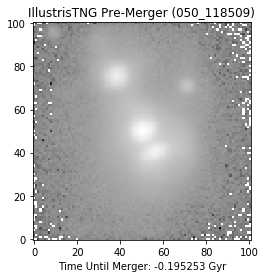

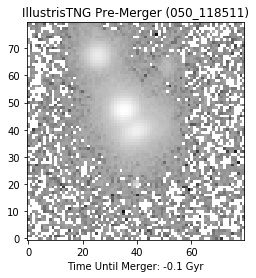

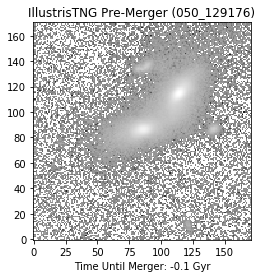

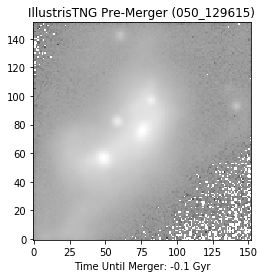

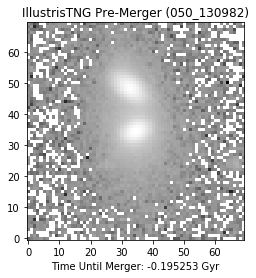

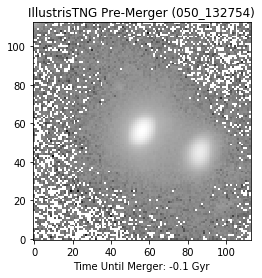

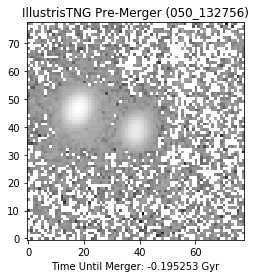

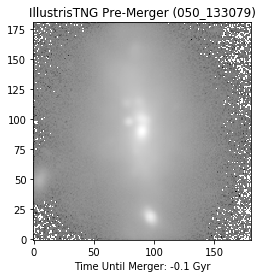

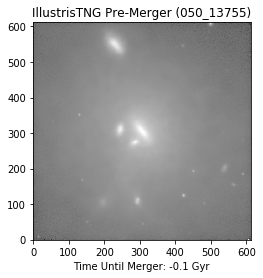

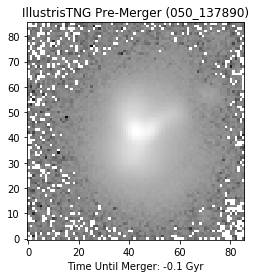

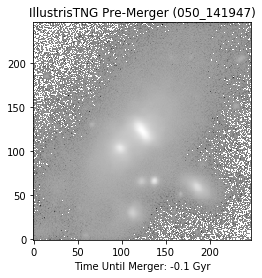

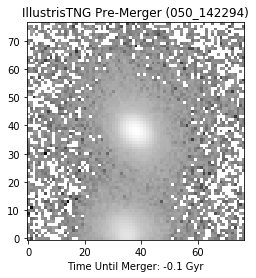

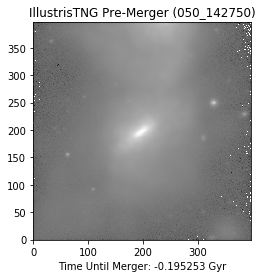

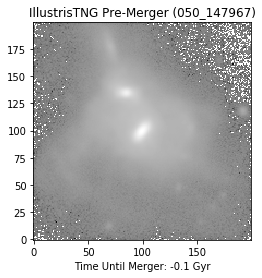

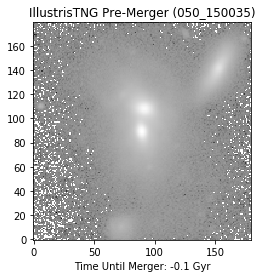

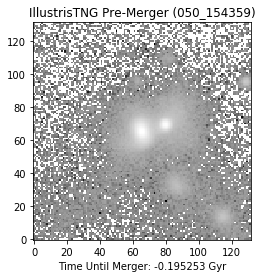

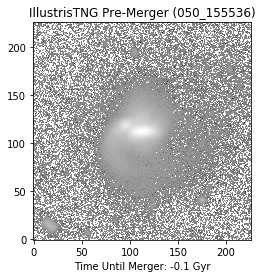

In [10]:
n_images = 20
for i in range(n_images):
    show_image(names_db_pre[i], Tum_pre[i], pre_post = 'pre', user = 'Hossen')

### Post-Mergers:

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log10


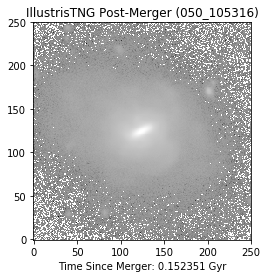

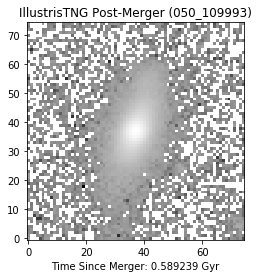

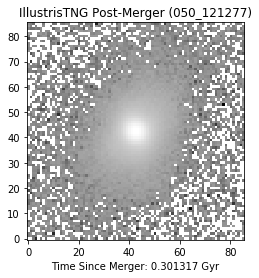

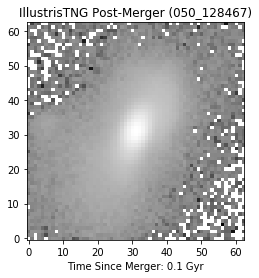

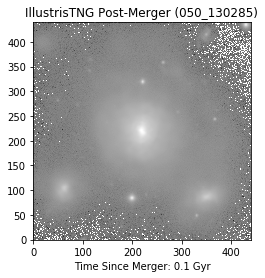

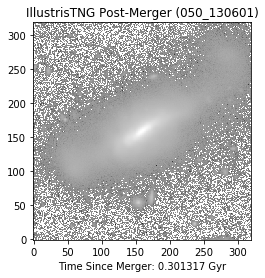

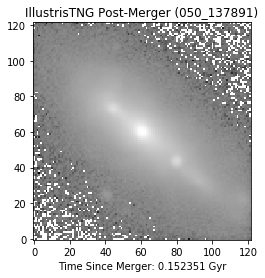

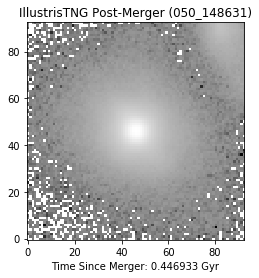

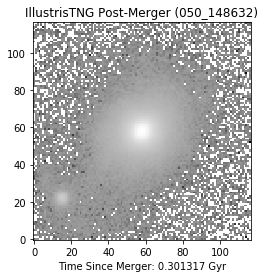

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10


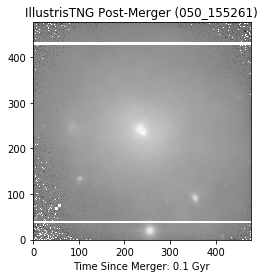

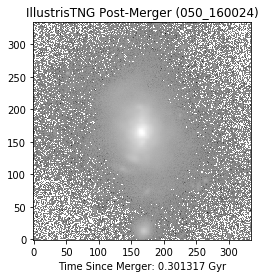

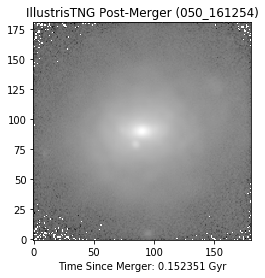

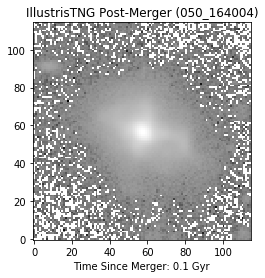

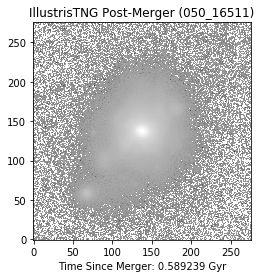

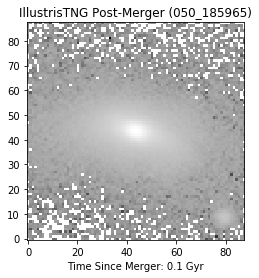

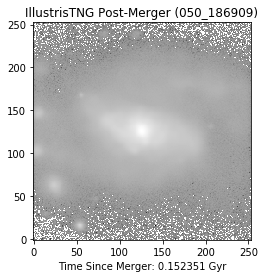

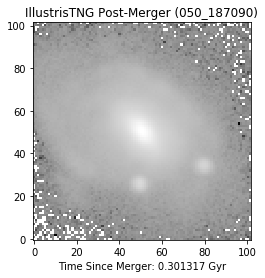

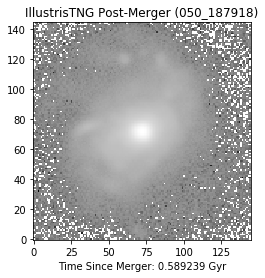

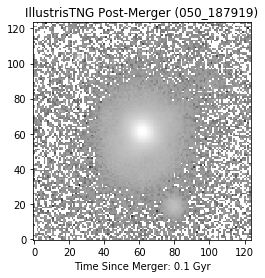

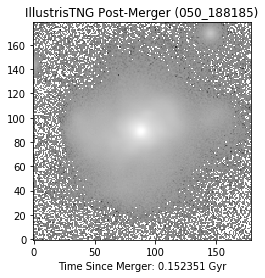

In [11]:
n_images = 20
for i in range(n_images):
    show_image(names_db_post[i], Tpm_post[i], pre_post = 'post', user = 'Hossen')

# Will non-parametric morphology statistics be able to help?

In [12]:
# define a moving average function
def movav(x, y, MIN, MAX, nbins):
    
    x = np.array(x)
    y = np.array(y)
    
    edges = np.linspace(MIN, MAX, nbins+1)
    
    print(len(x),len(y), len(edges), nbins)
    
    avs = [np.mean(y[(x>edges[i]) & (x<edges[i+1])]) for i in range(nbins)]
    
    centres = [(edges[i] + edges[i+1])/2. for i in range(nbins)]
    
    return np.array(centres), np.array(avs)

In [13]:
# list of all merging galaxies
names_mergers = np.array(list(names_db_pre) + list(names_db_post))
T_merger = np.array(list(Tum_pre) + list(Tpm_post))

match, idx_morph, idx_merge = np.intersect1d(names_morph, names_mergers, return_indices = True)

T_merger = T_merger[idx_merge]

#### The following plots show that non-parametric morphologies may allow us to differentiate between pre- and post-merger galaxies and predict a time of merger given a galaxy's morphology!

6179 6179 13 12


/astro/swilkinson/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/astro/swilkinson/.local/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


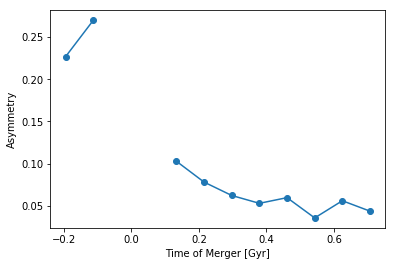

6179 6179 13 12


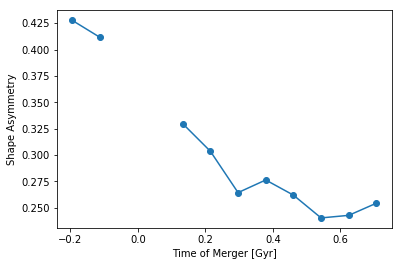

6179 6179 13 12


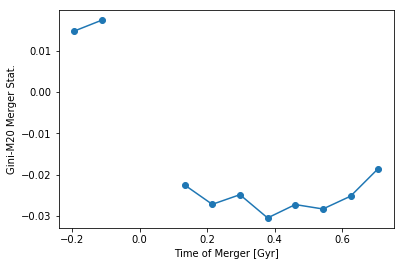

6179 6179 13 12


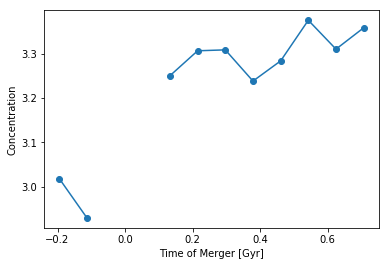

6179 6179 13 12


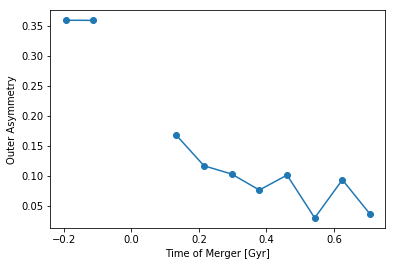

6179 6179 13 12


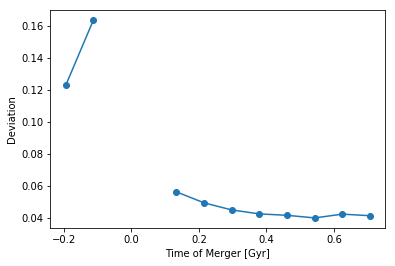

6179 6179 13 12


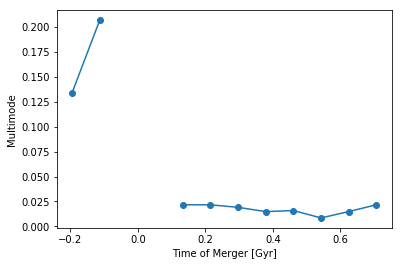

6179 6179 13 12


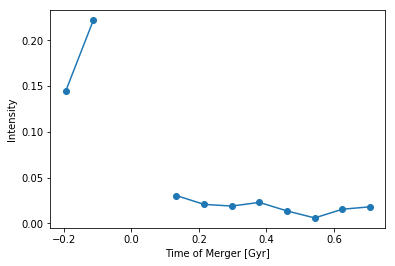

In [14]:
ylabels = ['Asymmetry', 'Shape Asymmetry', 'Gini-M20 Merger Stat.', 'Concentration','Outer Asymmetry', 'Deviation', 'Multimode', 'Intensity']
for i in range(len(data)):
    
    x = T_merger
    y = morph[i][idx_morph]
    
    plt.figure()
    plt.plot(*movav(x,y,min(x),max(x),12), 'o-')
    plt.xlabel('Time of Merger [Gyr]')
    plt.ylabel(ylabels[i])
    plt.show()